# A fast velocity computation

## Makes a synthetic set

In [339]:
import MotionClouds as mc
N_X, N_X_up, N_T = 32, 512, 256
fx, fy, ft = mc.get_grids(N_X, N_X_up, 1)
sf_0=0.02
env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=sf_0, V_X=0., V_Y=0., B_V=0)
x = 2 * mc.rectif(mc.random_cloud(env, seed=1973))[0, :] - 1

In [340]:
mc.envelope_gabor?

Signature:
mc.envelope_gabor(
    fx,
    fy,
    ft,
    V_X=1.0,
    V_Y=0.0,
    B_V=0.5,
    sf_0=0.125,
    B_sf=0.1,
    loggabor=True,
    theta=0.0,
    B_theta=0.19634954084936207,
    alpha=0.0,
    **kwargs,
)
Docstring:
Returns the Motion Cloud kernel, that is the product of:
    * a speed envelope
    * an orientation envelope
    * an orientation envelope
File:      /usr/local/lib/python3.9/site-packages/MotionClouds.py
Type:      function


In [341]:
def sigmoid(x):
    return 2 / (1 + np.exp(-x)) - 1
z = np.tanh(3*x)

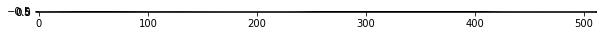

In [342]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(z.T, cmap=plt.gray())

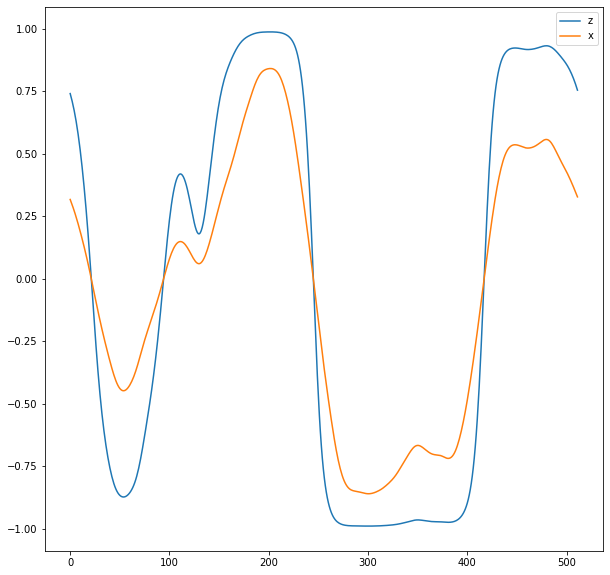

In [343]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.plot(z, label='z')
_ = ax.plot(x, label='x')
plt.legend();

In [344]:
import numpy as np

In [345]:
noise = 0.05
I_noise = noise * np.random.randn(N_X, N_T)

In [346]:
up = int(N_X_up/N_X)

In [347]:
I = np.zeros((N_X, N_T))
for i_T in range(N_T):
    I[:, i_T] = np.roll(z, int(i_T*N_X_up/N_T))[::up, 0] 
I += I_noise

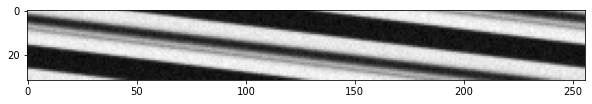

In [348]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(I, cmap=plt.gray())

## transform to events

In [349]:
np.gradient?

Signature: np.gradient(f, *varargs, axis=None, edge_order=1)
Docstring:
Return the gradient of an N-dimensional array.

The gradient is computed using second order accurate central differences
in the interior points and either first or second order accurate one-sides
(forward or backwards) differences at the boundaries.
The returned gradient hence has the same shape as the input array.

Parameters
----------
f : array_like
    An N-dimensional array containing samples of a scalar function.
varargs : list of scalar or array, optional
    Spacing between f values. Default unitary spacing for all dimensions.
    Spacing can be specified using:

    1. single scalar to specify a sample distance for all dimensions.
    2. N scalars to specify a constant sample distance for each dimension.
       i.e. `dx`, `dy`, `dz`, ...
    3. N arrays to specify the coordinates of the values along each
       dimension of F. The length of the array must match the size of
       the corresponding dimensio

In [350]:
print(I.min(), I.max())

-1.1607064573656483 1.124905119858291


In [351]:
#I[20:40, 40:80] = 0
#Ix = np.gradient(I, axis=0)
It = np.gradient(I, axis=1)

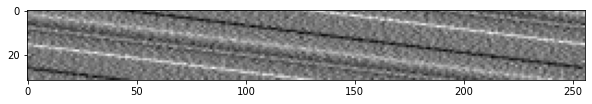

In [352]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It, cmap=plt.gray())

In [353]:
print(It.min(), It.max())

-0.2432377553590127 0.277742840302268


In [354]:
threshold = 0.15

In [355]:
It_ = It.copy()
It_event = np.zeros((N_X, N_T))
for i_T in range(N_T-1):
    It_event[:, i_T] = 1. * (It_[:, i_T] > threshold) - 1. * (It_[:, i_T] < -threshold)
    It_[:, i_T+1] -= threshold * It_event[:, i_T]
#It_event[:, -1] = 0

In [356]:
print(It_event.min(), It_event.max())
print(It_.min(), It_.max())

-1.0 1.0
-0.22516289858025695 0.25809200264756404


In [357]:
np.lookfor('seismic')

Search results for 'seismic'
----------------------------
Nothing found.


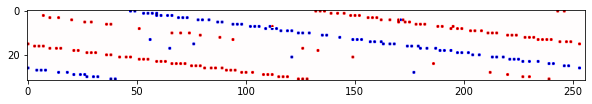

In [358]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event, cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [359]:
It_event[:, 0], It_event[:, 10], It_event[:, -1], It_event.shape

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (32, 256))

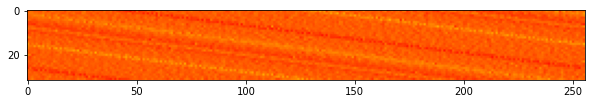

In [360]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_, cmap=plt.hot(), vmin=-1, vmax=1)

## motion compensated transform on events

In [361]:
It_v = np.zeros((N_X, N_T))
V = .5
for i_T in range(N_T):
    It_v[:, i_T] = np.roll(It_event[:, i_T], -int(V*N_X/N_T*i_T))

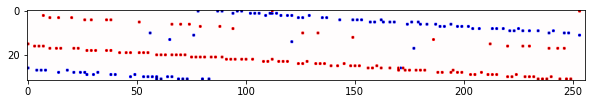

In [362]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_v, cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [363]:
It_v[:, 0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -1.,  0.,  0.,  0.,  0.,  0.])

In [364]:
p_V_plus = np.sum(It_v==1, axis=1)*1.
p_V_minus = np.sum(It_v==-1, axis=1)*1.

p_V_plus /= np.sum(p_V_plus)
p_V_minus /= np.sum(p_V_minus)

In [365]:
np.sum(p_V_minus)

1.0

(0.0, 0.07819148936170213)

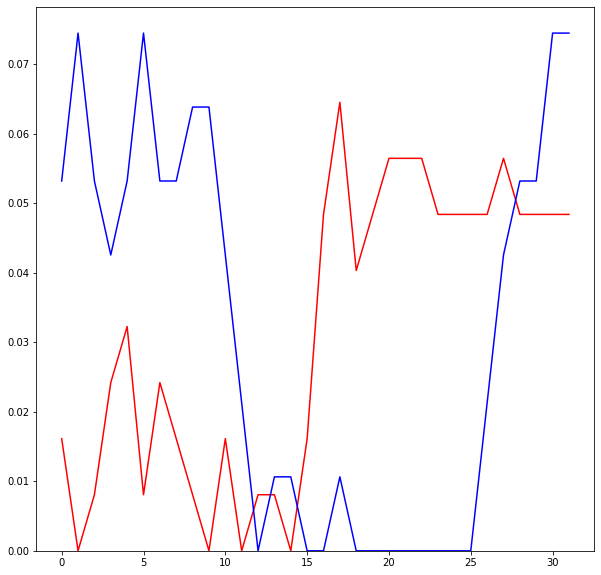

In [366]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(p_V_plus, c='r')
ax.plot(p_V_minus, c='b')
ax.set_ylim(0)

In [367]:
entropy = -np.sum( p_V_minus * np.log2(p_V_minus + 1.*(p_V_minus==0)) )
entropy += -np.sum( p_V_plus * np.log2(p_V_plus + 1.*(p_V_plus==0)) )

In [368]:
entropy

8.802530860743737

## transform as an event list

In [369]:
It_v.shape

(32, 256)

In [370]:
torch.nonzero(torch.Tensor(It_v)).shape, torch.nonzero(torch.Tensor(It_v==1)).shape, torch.nonzero(torch.Tensor(It_v==-1)).shape

(torch.Size([218, 2]), torch.Size([124, 2]), torch.Size([94, 2]))

In [371]:
events = torch.nonzero(torch.Tensor(It_v))
events.shape, torch.ones(events.shape[0], 1).shape

(torch.Size([218, 2]), torch.Size([218, 1]))

In [372]:
events = torch.hstack((events, torch.ones(events.shape[0], 1)))
events.shape

torch.Size([218, 3])

In [373]:
events[:10, :]

tensor([[  0.,  78.,   1.],
        [  0.,  87.,   1.],
        [  0.,  89.,   1.],
        [  0.,  96.,   1.],
        [  0.,  98.,   1.],
        [  0., 112.,   1.],
        [  0., 253.,   1.],
        [  1.,  94.,   1.],
        [  1., 102.,   1.],
        [  1., 104.,   1.]])

x, t, p

In [374]:
events[:, 0].max(), events[:, 1].max(), events[:, 2].max()

(tensor(31.), tensor(253.), tensor(1.))

In [375]:
x, t

(array([[ 0.31730986],
        [ 0.30663412],
        [ 0.29558403],
        [ 0.28411182],
        [ 0.27218245],
        [ 0.25977617],
        [ 0.24688765],
        [ 0.2335235 ],
        [ 0.2196997 ],
        [ 0.2054392 ],
        [ 0.19077022],
        [ 0.17572549],
        [ 0.16033844],
        [ 0.14463303],
        [ 0.12861174],
        [ 0.11225096],
        [ 0.09550855],
        [ 0.07833989],
        [ 0.06071449],
        [ 0.04262775],
        [ 0.02410637],
        [ 0.00520637],
        [-0.01399415],
        [-0.03339966],
        [-0.05289925],
        [-0.07237426],
        [-0.09171191],
        [-0.11081942],
        [-0.12963082],
        [-0.14810451],
        [-0.16621787],
        [-0.18396137],
        [-0.2013336 ],
        [-0.21834163],
        [-0.23500407],
        [-0.25134799],
        [-0.2674004 ],
        [-0.283182  ],
        [-0.29870393],
        [-0.31396322],
        [-0.32893454],
        [-0.34356145],
        [-0.35775164],
        [-0

In [376]:
events[:10, :]

tensor([[  0.,  78.,   1.],
        [  0.,  87.,   1.],
        [  0.,  89.,   1.],
        [  0.,  96.,   1.],
        [  0.,  98.,   1.],
        [  0., 112.,   1.],
        [  0., 253.,   1.],
        [  1.,  94.,   1.],
        [  1., 102.,   1.],
        [  1., 104.,   1.]])

Another solution:

In [377]:
events_neg = torch.nonzero(torch.Tensor(It_v==-1))
events_neg.shape, torch.ones(events_neg.shape[0], 1).shape

(torch.Size([94, 2]), torch.Size([94, 1]))

In [378]:
events_neg = torch.hstack((events_neg, -1 * torch.ones(events_neg.shape[0], 1)))
events_neg.shape

torch.Size([94, 3])

In [379]:
events_pos = torch.nonzero(torch.Tensor(It_v==1))
events_pos = torch.hstack((events_pos, torch.ones(events_pos.shape[0], 1)))
events_pos.shape

torch.Size([124, 3])

In [380]:
events = torch.vstack((events_pos, events_neg))
events.shape

torch.Size([218, 3])

In [381]:
events[:10, :]

tensor([[  0., 112.,   1.],
        [  0., 253.,   1.],
        [  2.,   7.,   1.],
        [  3.,  10.,   1.],
        [  3.,  14.,   1.],
        [  3.,  20.,   1.],
        [  4.,  26.,   1.],
        [  4.,  29.,   1.],
        [  4.,  36.,   1.],
        [  4.,  38.,   1.]])

In [382]:
torch.sort?

Docstring:
sort(input, dim=-1, descending=False, stable=False, *, out=None) -> (Tensor, LongTensor)

Sorts the elements of the :attr:`input` tensor along a given dimension
in ascending order by value.

If :attr:`dim` is not given, the last dimension of the `input` is chosen.

If :attr:`descending` is ``True`` then the elements are sorted in descending
order by value.

If :attr:`stable` is ``True`` then the sorting routine becomes stable, preserving
the order of equivalent elements.

A namedtuple of (values, indices) is returned, where the `values` are the
sorted values and `indices` are the indices of the elements in the original
`input` tensor.

Args:
    input (Tensor): the input tensor.
    dim (int, optional): the dimension to sort along
    descending (bool, optional): controls the sorting order (ascending or descending)
    stable (bool, optional): makes the sorting routine stable, which guarantees that the order
       of equivalent elements is preserved.

Keyword args:
    out 

In [383]:
times, indices = torch.sort(events[:, 1])
events = events[indices, :]

In [385]:
# x, t, p
events[:10, :]

tensor([[26.,  0., -1.],
        [15.,  0.,  1.],
        [16.,  3.,  1.],
        [27.,  4., -1.],
        [16.,  5.,  1.],
        [27.,  6., -1.],
        [16.,  7.,  1.],
        [ 2.,  7.,  1.],
        [27.,  8., -1.],
        [17., 10.,  1.]])

## gradient descent optimization

In [254]:
import torch
torch.roll?

Docstring:
roll(input, shifts, dims=None) -> Tensor

Roll the tensor along the given dimension(s). Elements that are shifted beyond the
last position are re-introduced at the first position. If a dimension is not
specified, the tensor will be flattened before rolling and then restored
to the original shape.

Args:
    input (Tensor): the input tensor.
    shifts (int or tuple of ints): The number of places by which the elements
        of the tensor are shifted. If shifts is a tuple, dims must be a tuple of
        the same size, and each dimension will be rolled by the corresponding
        value
    dims (int or tuple of ints): Axis along which to roll

Example::

    >>> x = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8]).view(4, 2)
    >>> x
    tensor([[1, 2],
            [3, 4],
            [5, 6],
            [7, 8]])
    >>> torch.roll(x, 1, 0)
    tensor([[7, 8],
            [1, 2],
            [3, 4],
            [5, 6]])
    >>> torch.roll(x, -1, 0)
    tensor([[3, 4],
            [5

In [255]:
torch.floor?

Docstring:
floor(input, *, out=None) -> Tensor

Returns a new tensor with the floor of the elements of :attr:`input`,
the largest integer less than or equal to each element.

.. math::
    \text{out}_{i} = \left\lfloor \text{input}_{i} \right\rfloor

Args:
    input (Tensor): the input tensor.

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> a = torch.randn(4)
    >>> a
    tensor([-0.8166,  1.5308, -0.2530, -0.2091])
    >>> torch.floor(a)
    tensor([-1.,  1., -1., -1.])
Type:      builtin_function_or_method


In [189]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
# https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html
criterion = torch.nn.BCELoss(reduction="sum")

class EMD(torch.nn.Module):
    def __init__(self, u=-20.):
        super(EMD, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.u = torch.nn.Parameter(u * torch.ones(1), requires_grad=True)

    def forward(self, It_event):
        It_v = self.u * It_event #torch.zeros_like(It_event)
        #for i_T in range(N_T):
        #    It_v[:, i_T] = torch.roll(It_event[:, i_T], -int(self.u*N_X/N_T*i_T))

        p_V_plus = torch.sum(It_v, axis=1)*1.
        p_V_minus = torch.sum(It_v==-1, axis=1)*1.

        p_V_plus /= torch.sum(p_V_plus)
        p_V_minus /= torch.sum(p_V_minus)
        
        return p_V_plus#, p_V_minus

In [185]:
m = torch.nn.Sigmoid()
criterion = torch.nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
loss = criterion(m(input), target)
loss.backward()

In [186]:
output, target

(tensor(0.5757, grad_fn=<BinaryCrossEntropyBackward0>), tensor([0., 0., 1.]))

In [176]:
torch.empty(3), torch.empty(3).random_(2), torch.empty(3).random_(1)

(tensor([2.1373e-314, 2.1386e-314, 2.1374e-314]),
 tensor([0., 1., 1.]),
 tensor([0., 0., 0.]))

In [177]:
torch.Tensor.random_?

Docstring:
random_(from=0, to=None, *, generator=None) -> Tensor

Fills :attr:`self` tensor with numbers sampled from the discrete uniform
distribution over ``[from, to - 1]``. If not specified, the values are usually
only bounded by :attr:`self` tensor's data type. However, for floating point
types, if unspecified, range will be ``[0, 2^mantissa]`` to ensure that every
value is representable. For example, `torch.tensor(1, dtype=torch.double).random_()`
will be uniform in ``[0, 2^53]``.
Type:      method_descriptor


In [178]:
N_X, N_T = It_event.shape
P_uniform = torch.ones(N_X) / N_X
It_event_ = torch.Tensor(It_event)
print(P_uniform, It_event_.shape)

tensor([0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156]) torch.Size([64, 128])


In [190]:
emd = EMD()
emd.train()
It_event_ = torch.Tensor(It_event)
out = emd(It_event_)
out

tensor([ 0.1667,  0.1667,  0.0000, -0.1667,  0.0000,  0.0833,  0.0000,  0.1667,
        -0.2500,  0.0833,  0.0000,  0.0000,  0.1667,  0.0000,  0.0833,  0.1667,
         0.0000, -0.0833, -0.2500, -0.1667, -0.0833,  0.0000,  0.0000,  0.0833,
         0.0833,  0.0000,  0.1667,  0.0000,  0.0833,  0.0000,  0.0000,  0.0000,
         0.0000, -0.1667, -0.1667,  0.0000,  0.1667,  0.0833,  0.2500, -0.1667,
        -0.0833,  0.0000, -0.1667, -0.0833,  0.1667,  0.0000,  0.1667, -0.0833,
        -0.1667,  0.1667,  0.2500,  0.0833,  0.0000, -0.0833, -0.0833,  0.0833,
         0.0000,  0.1667,  0.1667,  0.0000, -0.1667,  0.0833, -0.0833,  0.1667],
       grad_fn=<DivBackward0>)

In [181]:
p_V_plus, p_V_minus = emd(It_event_)
print(p_V_plus, p_V_minus)

tensor([0.0201, 0.0201, 0.0161, 0.0161, 0.0141, 0.0121, 0.0181, 0.0141, 0.0181,
        0.0161, 0.0101, 0.0121, 0.0201, 0.0121, 0.0181, 0.0161, 0.0181, 0.0161,
        0.0141, 0.0161, 0.0141, 0.0121, 0.0161, 0.0141, 0.0181, 0.0181, 0.0141,
        0.0161, 0.0221, 0.0161, 0.0221, 0.0161, 0.0141, 0.0141, 0.0080, 0.0181,
        0.0161, 0.0080, 0.0161, 0.0141, 0.0181, 0.0161, 0.0121, 0.0121, 0.0141,
        0.0141, 0.0161, 0.0161, 0.0080, 0.0141, 0.0181, 0.0181, 0.0201, 0.0141,
        0.0221, 0.0181, 0.0101, 0.0161, 0.0161, 0.0141, 0.0201, 0.0141, 0.0161,
        0.0161]) tensor([0.0098, 0.0118, 0.0177, 0.0157, 0.0177, 0.0138, 0.0138, 0.0216, 0.0196,
        0.0216, 0.0157, 0.0138, 0.0118, 0.0059, 0.0196, 0.0216, 0.0138, 0.0118,
        0.0157, 0.0236, 0.0177, 0.0196, 0.0079, 0.0138, 0.0157, 0.0177, 0.0196,
        0.0098, 0.0138, 0.0138, 0.0177, 0.0118, 0.0196, 0.0236, 0.0177, 0.0138,
        0.0177, 0.0098, 0.0196, 0.0118, 0.0157, 0.0196, 0.0196, 0.0177, 0.0216,
        0.0118, 0.0118,

In [182]:
criterion(p_V_plus, P_uniform), criterion(p_V_minus, P_uniform)

(tensor(5.1745), tensor(5.1899))

In [169]:
emd.u

Parameter containing:
tensor([-20.], requires_grad=True)

In [172]:
p_V_plus, p_V_minus = emd(It_event_)
p_V_plus

tensor([0.0121, 0.0221, 0.0181, 0.0101, 0.0161, 0.0161, 0.0141, 0.0161, 0.0141,
        0.0121, 0.0181, 0.0141, 0.0161, 0.0121, 0.0141, 0.0201, 0.0101, 0.0161,
        0.0141, 0.0161, 0.0201, 0.0121, 0.0181, 0.0161, 0.0161, 0.0121, 0.0161,
        0.0121, 0.0161, 0.0121, 0.0221, 0.0141, 0.0201, 0.0181, 0.0141, 0.0161,
        0.0161, 0.0080, 0.0241, 0.0121, 0.0262, 0.0101, 0.0201, 0.0121, 0.0181,
        0.0121, 0.0141, 0.0161, 0.0241, 0.0161, 0.0121, 0.0241, 0.0040, 0.0241,
        0.0141, 0.0121, 0.0161, 0.0161, 0.0161, 0.0181, 0.0080, 0.0121, 0.0181,
        0.0181])

In [170]:
emd.u = torch.nn.Parameter(-1 * torch.ones(1))
emd.u.requires_grad = True
p_V_plus, p_V_minus = emd(It_event_)
loss = criterion(p_V_plus, P_uniform) + criterion(p_V_minus, P_uniform)
loss

tensor(10.3808)

In [146]:
p_V_plus.shape, P_uniform.shape

(torch.Size([64]), torch.Size([64]))

In [ ]:
m = torch.nn.Sigmoid()
loss = torch.nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(p_V_plus, P_uniform)

In [144]:
loss.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [140]:
optimizer.step()
losses.append(loss.item())

NameError: name 'optimizer' is not defined

In [95]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256

def fit_data(It_event, learning_rate=learning_rate, 
             num_epochs=num_epochs, betas=betas, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_X, N_T = It_event.shape
    P_uniform = torch.ones(N_X) / N_X
    entropy = criterion(P_uniform, P_uniform)
    
    It_event_ = torch.Tensor(It_event)
    It_event_ = It_event_.to(device)
        
    emd = EMD()
    emd = emd.to(device)
    emd.train()
    
    optimizer = torch.optim.Adam(emd.parameters(), lr=learning_rate, betas=betas)
    
    for epoch in range(int(num_epochs)):
        losses = []
        p_V_plus, p_V_minus = emd(It_event_)
        
        loss = criterion(p_V_plus, P_uniform)
        loss += criterion(p_V_minus, P_uniform)
        print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.5f}")

    return emd, loss

emd, loss = fit_data(It_event, verbose=True)

tensor(10.3270)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [86]:
emd = EMD()
#emd = emd.to(device)
emd.train()

EMD()

In [87]:
emd.u

Parameter containing:
tensor([0.], requires_grad=True)

In [98]:
for p in emd.parameters():
    print(p)

Parameter containing:
tensor([-1.], requires_grad=True)


In [319]:
kl_loss?

Signature:      kl_loss(*input, **kwargs)
Type:           KLDivLoss
String form:    KLDivLoss()
File:           /usr/local/lib/python3.9/site-packages/torch/nn/modules/loss.py
Docstring:     
The Kullback-Leibler divergence loss measure

`Kullback-Leibler divergence`_ is a useful distance measure for continuous
distributions and is often useful when performing direct regression over
the space of (discretely sampled) continuous output distributions.

As with :class:`~torch.nn.NLLLoss`, the `input` given is expected to contain
*log-probabilities* and is not restricted to a 2D Tensor.
The targets are interpreted as *probabilities* by default, but could be considered
as *log-probabilities* with :attr:`log_target` set to ``True``.

This criterion expects a `target` `Tensor` of the same size as the
`input` `Tensor`.

The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:

.. math::
    l(x,y) = L = \{ l_1,\dots,l_N \}, \quad
    l_n = y_n \cdot \left( \log y_

In [199]:
import torch.nn.functional as F
from torch import nn
kl_loss = nn.KLDivLoss(reduction="batchmean")
# input should be a distribution in the log space
input = F.log_softmax(torch.randn(3, 5, requires_grad=True), dim=1)
# Sample a batch of distributions. Usually this would come from the dataset
target = F.softmax(torch.rand(3, 5), dim=1)
output = kl_loss(input, target)

In [200]:
output

tensor(0.3229, grad_fn=<DivBackward0>)

In [219]:
kl_loss(F.log_softmax(torch.randn(3, 5), dim=1), F.softmax(torch.randn(3, 5), dim=1))

tensor(0.6273)

In [234]:
kl_loss(F.log_softmax(torch.randn(30, 5), dim=1), F.softmax(torch.randn(30, 5), dim=1))

tensor(0.8569)

In [311]:
log_p, q = F.log_softmax(torch.rand(30, 5), dim=1), F.softmax(torch.rand(30, 5), dim=1)
log_q = F.log_softmax(q, dim=1)
kl_loss(log_p, q), kl_loss(log_q, q)

(tensor(0.0633), tensor(0.0190))

In [320]:
p = torch.rand(30, 5)
log_p = F.log_softmax(p, dim=1)
kl_loss(log_p, q), kl_loss(log_q, q)

(tensor(0.0663), tensor(0.0190))

In [355]:
p = torch.rand(30, 5)
p[:10, 0] = .001
log_p = F.log_softmax(p, dim=1)
kl_loss(log_p, q), kl_loss(log_q, q)

(tensor(0.0691), tensor(0.0190))

In [303]:
log_p = F.log_softmax(torch.rand(30, 5), dim=1)
kl_loss(log_p, q), kl_loss(log_q, q)

(tensor(0.4072), tensor(0.2175))

In [201]:
kl_loss(F.log_softmax(torch.randn(3, 5), dim=1), F.softmax(torch.rand(3, 5), dim=1))

tensor(0.4812)

In [201]:
kl_loss(F.log_softmax(torch.randn(3, 5), dim=1), F.softmax(torch.rand(3, 5), dim=1))

tensor(0.4812)

In [202]:
kl_loss(F.log_softmax(torch.randn(3, 5), dim=1), F.softmax(torch.randn(3, 5), dim=1))

tensor(0.4515)

In [201]:
kl_loss(F.log_softmax(torch.randn(3, 5), dim=1), F.softmax(torch.rand(3, 5), dim=1))

tensor(0.4812)

In [196]:
kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
log_target = F.log_softmax(torch.rand(3, 5), dim=1)
output = kl_loss(input, log_target)

In [197]:
output

tensor(0.4314, grad_fn=<DivBackward0>)